# Tesla - Stock Price Prediction Using Text Data

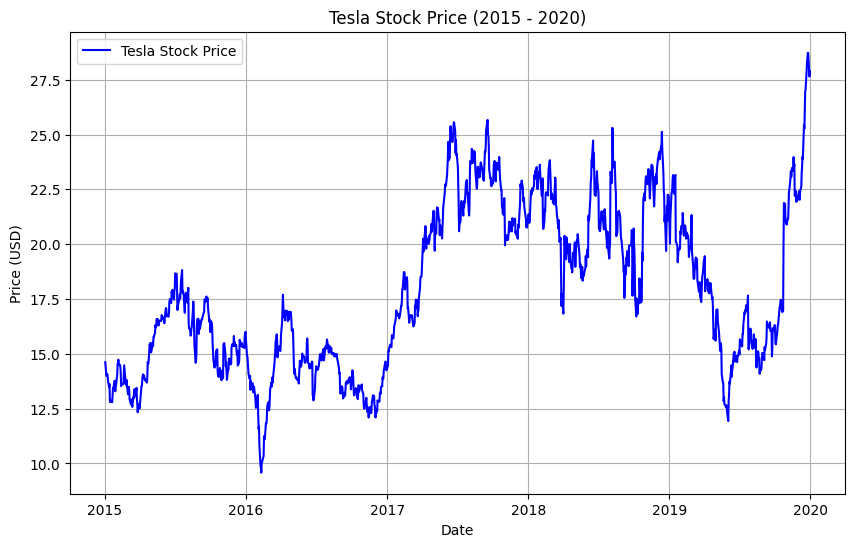

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import zipfile
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

tesla = yf.Ticker("TSLA")

# Fetching historical data
tesla_data = tesla.history(start="2015-01-01", end="2020-01-01")

# Plotting the closing prices
plt.figure(figsize=(10, 6))
plt.plot(tesla_data.index, tesla_data['Close'], label='Tesla Stock Price', color='b')
plt.title('Tesla Stock Price (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Data Preprocessing and EDA

### Loading Datasets

#### Unzipping Files

In [62]:
file_paths = ["/content/Tweet.csv.zip", "/content/Company_Tweet.csv.zip", "/content/tesla_2018_to_2020.csv.zip"]

for file_path in file_paths:
    try:
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall("/content")
        print(f"Successfully extracted: {file_path}")
    except zipfile.BadZipFile:
        print(f"Error: {file_path} is not a valid zip file.")
    except FileNotFoundError:
        print(f"Error: {file_path} not found.")

Successfully extracted: /content/Tweet.csv.zip
Successfully extracted: /content/Company_Tweet.csv.zip
Error: /content/tesla_2018_to_2020.csv.zip not found.


### Reading in data

In [70]:
tweets1_df = pd.DataFrame(pd.read_csv("/content/Tweet.csv", index_col=0))

tweets1_companies_df = pd.DataFrame(pd.read_csv("/content/Company_Tweet.csv", index_col=0))
print(f"Shape: {tweets1_df.shape}")

Shape: (3717964, 6)


Converting the dates from their original Unix time to date time

In [71]:
tweets1_df['post_date'] = pd.to_datetime(tweets1_df['post_date'], unit='s')
tweets1_df.head()

,writer,post_date,body,comment_num,retweet_num,like_num
tweet_id,,,,,,
550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
550441672312512512,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0
550441732014223360,DozenStocks,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
550443807834402816,i_Know_First,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


Keeping only the tweets that mention TSLA stock

In [72]:
# Returns the tweet IDs of the tweets mentioning TSLA
indices_to_keep = (tweets1_companies_df[tweets1_companies_df['ticker_symbol'] == "TSLA"]).index
tweets1_df = tweets1_df.loc[indices_to_keep]

# Dropping duplicates in the 'body' and 'tweet_id' column
tweets1_df = tweets1_df.drop_duplicates(subset=['body'])
tweets1_df = tweets1_df[~tweets1_df.index.duplicated(keep='first')]
print(tweets1_df.shape)

(1016828, 6)


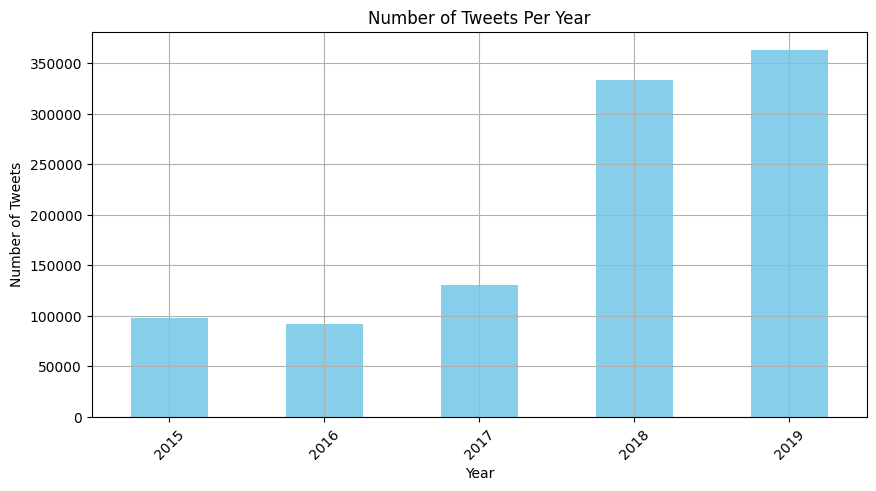

In [73]:
tweets1_df['Year'] = tweets1_df['post_date'].dt.year  # Extract year from the datetime

# Group by year and count the tweets
tweets_per_year = tweets1_df.groupby('Year').size()

# Plotting
plt.figure(figsize=(10, 5))
tweets_per_year.plot(kind='bar', color='skyblue')
plt.title('Number of Tweets Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Training Dataset (Jan. 2015- Dec. 2018)

In [8]:
def calculate_percent_change(start_date, end_date, label_type='Q'):

    ## GETTING TESLA STOCK DATA ##
    stock_data = yf.download('TSLA', start=start_date, end=end_date)

    # Here, we are resampling the data either weekly, monthly, or quarterly
    if label_type in ['W', 'M', 'Q']:
        open = stock_data['Open'].resample(label_type).first()
        close = stock_data['Close'].resample(label_type).last()
    else:
        raise ValueError("Invalid label_type. Choose 'W': weekly, 'M': monthly, or 'Q': quarterly")

    # Calculating and shifting the percent changes forward by one period to label tweets with future performance
    # For example, the percent change from Q2 will be used as the labels for the Q1 tweets
    pct_change = ((close - open) / open).shift(-1)
    return pct_change, close.index

def create_labeled_dataset(data, pct_change, start_date, end_date, period_dates, size=100000, random_seed=123):
    # Labeling the stock changes
    stock_labels = (pct_change > 0).astype(int)

    # Converting tweet dates to datetime and filtering data between start_date and end_date
    data['Date'] = pd.to_datetime(data['post_date'])
    data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    # Mapping labels to the dataframe based on the period right after the tweet
    # First, we must align labels with their respective period end dates
    labels_df = pd.DataFrame({'Target': stock_labels, 'Period_End': period_dates})

    # To efficiently find the next period's end date for each tweet, sort period ends
    sorted_period_ends = labels_df['Period_End'].sort_values().drop_duplicates().tolist()

    # Randomly select indices for the training data
    rng = np.random.default_rng(random_seed)
    train_indices = rng.choice(data.index, size=size, replace=False)
    train_data = data.loc[train_indices]

    # Map each tweet date to the next period end
    def get_next_period_end(tweet_date):
        for period_end in sorted_period_ends:
            if period_end > tweet_date:
                return period_end
        return sorted_period_ends[-1]

    # Applying the above mapping to each tweet date in training dataset
    train_data['Period_End'] = train_data['Date'].apply(get_next_period_end)

    # Merge labels with training data
    train_data = train_data.merge(labels_df, on='Period_End', how='left')

    # Drop any rows that didn't find a match (should be few, mostly the last period's tweets)
    train_data.dropna(subset=['Target'], inplace=True)

    # Resetting index before returning
    train_data.reset_index(drop=True, inplace=True)

    return train_data[['body', 'Target', 'Date']]

In [9]:
# Defining percent changes for 2015-2019 quarterly data. Note, when running the calculate_percent_change() function, should always include an extra time amount to make sure that final percent change value can be calculated
pct_changes, close_index = calculate_percent_change('2015-01-01', '2019-04-01', 'Q')
close_index = close_index[:-1]
pct_changes = pct_changes[:-1]

# This takes roughly a few minutes to run just because of the .min() operation that is need so that there are no incorrectly assigned labels
train_df_quarterly = create_labeled_dataset(tweets1_df, pct_changes, '2015-01-01', '2019-01-01', close_index, size=100000)

[*********************100%%**********************]  1 of 1 completed


In [10]:
train_df_quarterly.head()

,body,Target,Date
0,#Tesla Could Be Changing The Dynamics Of Globa...,0,2015-04-30 09:32:52
1,Tesla Down 8% Today... Stop Taking My Money (U...,0,2016-02-05 16:31:46
2,"$TSLA Tesla CEO Elon Musk tweets - ""Tesla is b...",1,2018-09-17 10:08:04
3,#investing #daytrading FRIDAY TOP ANALYST UPGR...,0,2017-10-27 13:24:33
4,"$TSLA - another ""I will gladly pay you Tuesday...",0,2015-05-06 21:00:22


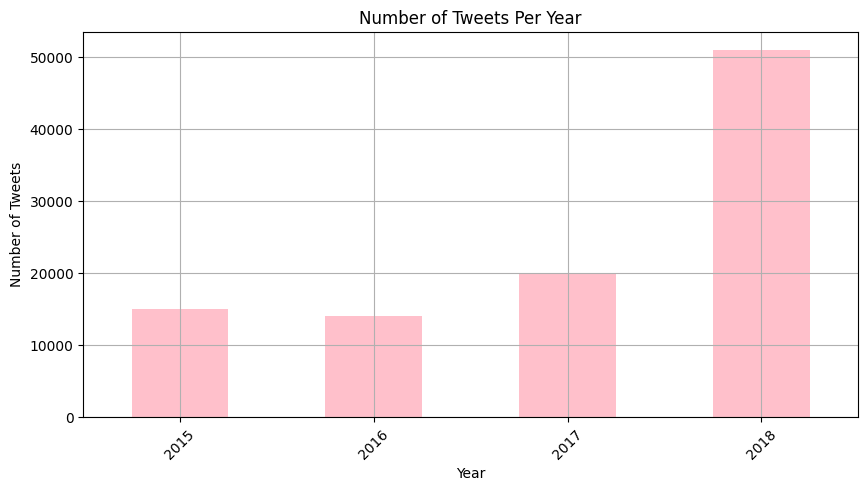

In [11]:
train_df_quarterly['Year'] = train_df_quarterly['Date'].dt.year  # Extract year from the datetime

# Group by year and count the tweets
tweets_per_year = train_df_quarterly.groupby('Year').size()

# Plotting
plt.figure(figsize=(10, 5))
tweets_per_year.plot(kind='bar', color='pink')
plt.title('Number of Tweets Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Training Data (01/01/2015 - 12/31/2018)

In [13]:
# WEEKLY TRAINING
pct_changes_w, close_index_w = calculate_percent_change('2015-01-01', '2019-01-10', 'W') # Extending time frame by one extra week
close_index_w = close_index_w[:-1]
pct_changes_w = pct_changes_w[:-1]
train_df_w = create_labeled_dataset(tweets1_df, pct_changes_w, '2015-01-01', '2019-01-01', close_index_w, size=100000)

# MONTHLY TRAINING
pct_changes_m, close_index_m = calculate_percent_change('2015-01-01', '2019-02-01', 'M') # Extending time frame by one extra month
close_index_m = close_index_m[:-1]
pct_changes_m = pct_changes_m[:-1]
train_df_m = create_labeled_dataset(tweets1_df, pct_changes_m, '2015-01-01', '2019-01-01', close_index_m, size=100000)

# QUARTERLY TRAINING
pct_changes_q, close_index_q = calculate_percent_change('2015-01-01', '2019-04-01', 'Q') # Extending time frame by one extra quarter
close_index_q = close_index_q[:-1]
pct_changes_q = pct_changes_q[:-1]
train_df_q = create_labeled_dataset(tweets1_df, pct_changes_q, '2015-01-01', '2019-01-01', close_index_q, size=100000)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Testing Data (01/01/2019 - 12/31/2019)

In [14]:
# WEEKLY TESTING
pct_changes_w, close_index_w = calculate_percent_change('2019-01-01', '2020-01-10', 'W') # Extending time frame by one extra week
close_index_w = close_index_w[:-1]
pct_changes_w = pct_changes_w[:-1]
test_df_w = create_labeled_dataset(tweets1_df, pct_changes_w, '2019-01-01', '2020-01-01', close_index_w, size=20000)

# MONTHLY TESTING
pct_changes_m, close_index_m = calculate_percent_change('2019-01-01', '2020-02-01', 'M') # Extending time frame by one extra month
close_index_m = close_index_m[:-1]
pct_changes_m = pct_changes_m[:-1]
test_df_m = create_labeled_dataset(tweets1_df, pct_changes_m, '2019-01-01', '2020-01-01', close_index_m, size=20000)

# QUARTERLY TESTING
pct_changes_q, close_index_q = calculate_percent_change('2019-01-01', '2020-04-01', 'Q') # Extending time frame by one extra quarter
close_index_q = close_index_q[:-1]
pct_changes_q = pct_changes_q[:-1]
test_df_q = create_labeled_dataset(tweets1_df, pct_changes_q, '2019-01-01', '2020-01-01', close_index_q, size=20000)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking to make sure indices look correct

In [15]:
# Note, these are the indices for the 2019 testing data
print(f"Weekly close index: {close_index_w[:5]}\n")
print(f"Monthly close index: {close_index_m[:5]}\n")
print(f"Quarterly close index: {close_index_q[:5]}\n")

Weekly close index: DatetimeIndex(['2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27',
               '2019-02-03'],
              dtype='datetime64[ns]', name='Date', freq='W-SUN')

Monthly close index: DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31'],
              dtype='datetime64[ns]', name='Date', freq='M')

Quarterly close index: DatetimeIndex(['2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31'], dtype='datetime64[ns]', name='Date', freq='Q-DEC')



Histogram of Labels

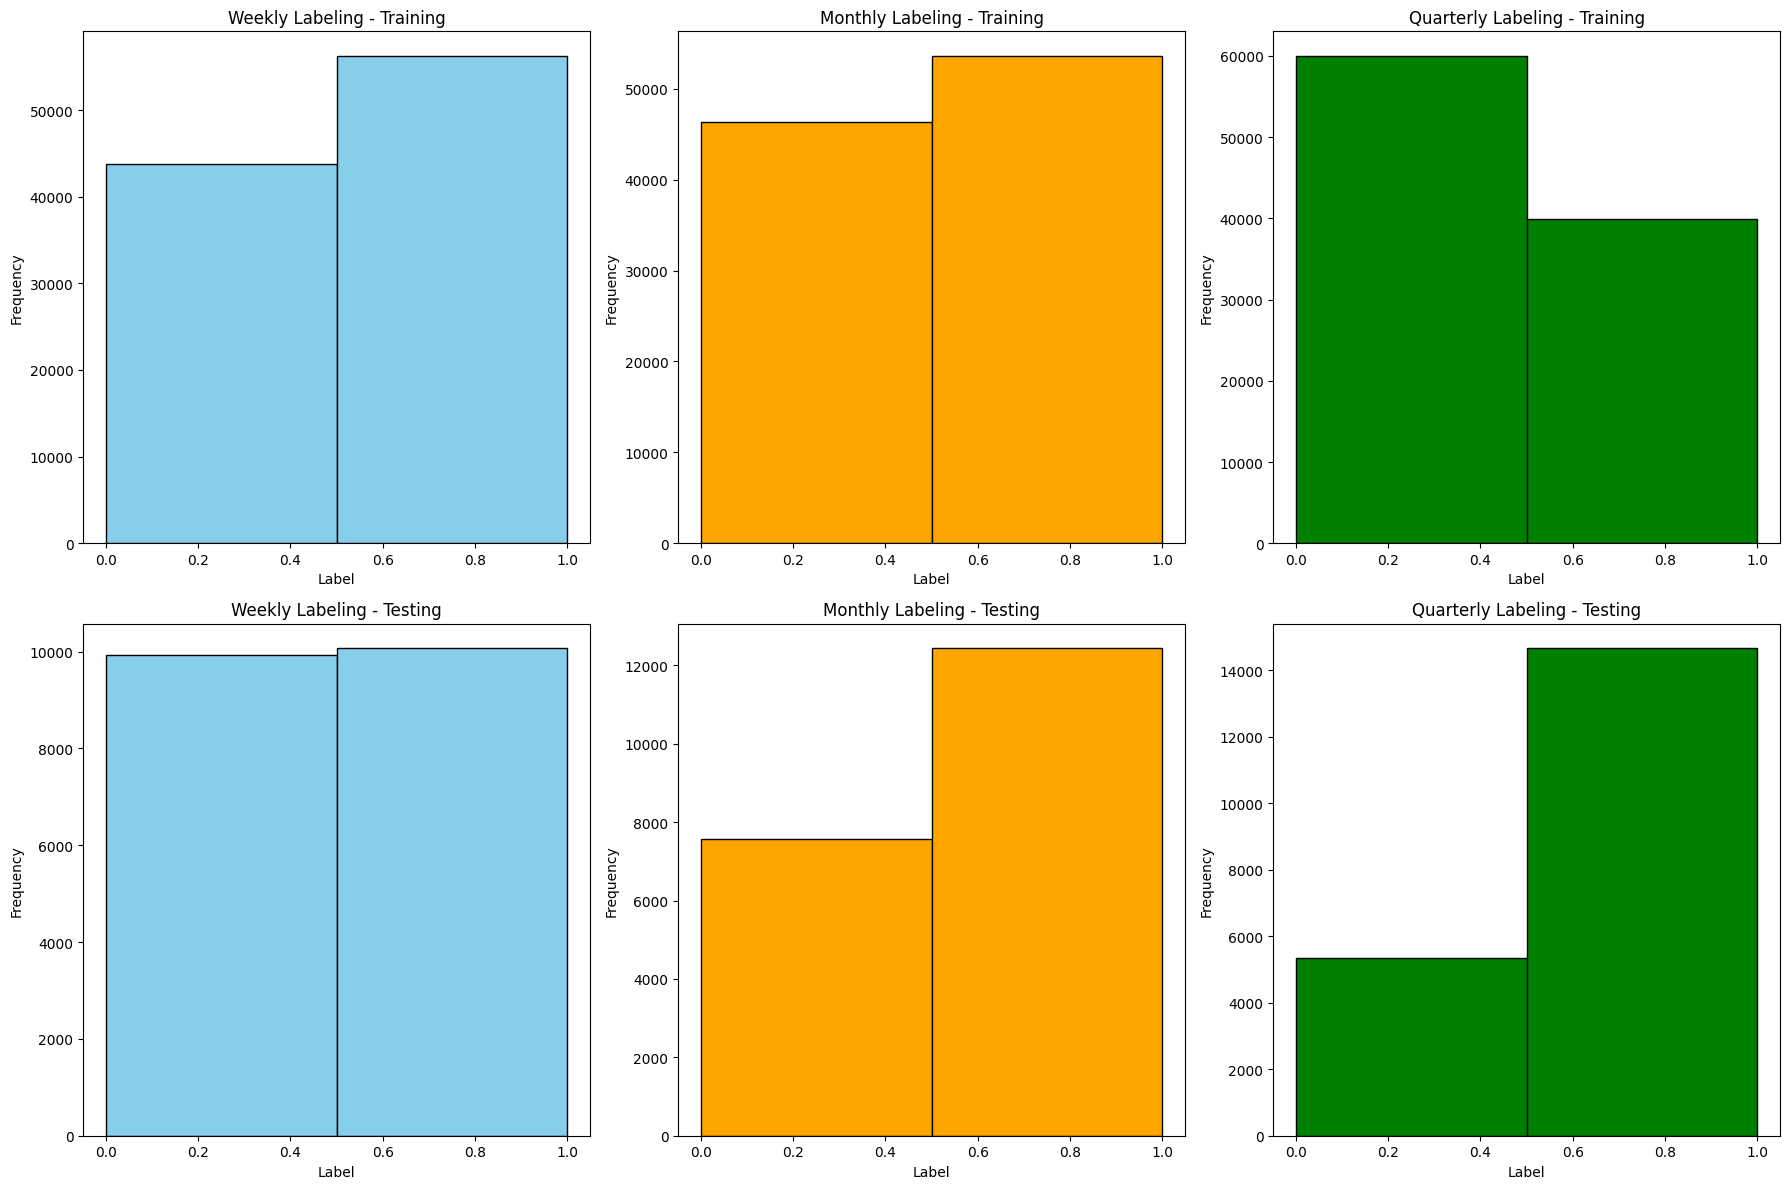

In [33]:
train_dfs = [train_df_w, train_df_m, train_df_q]
test_dfs = [test_df_w, test_df_m, test_df_q]
labels = ['Weekly', 'Monthly', 'Quarterly']
colors = ['skyblue', 'orange', 'green']

# Set up the figure for a 2x3 grid
plt.figure(figsize=(18, 12))

# Creating subplots for training data
for i, (df, label, color) in enumerate(zip(train_dfs, labels, colors), 1):
    plt.subplot(2, 3, i)
    df['Target'].plot(kind='hist', color=color, bins=2, edgecolor='black')
    plt.title(f'{label} Labeling - Training')
    plt.xlabel('Label')
    plt.ylabel('Frequency')

# Creating subplots for testing data
for i, (df, label, color) in enumerate(zip(test_dfs, labels, colors), 4):  # Start from position 4 in the grid
    plt.subplot(2, 3, i)
    df['Target'].plot(kind='hist', color=color, bins=2, edgecolor='black')
    plt.title(f'{label} Labeling - Testing')
    plt.xlabel('Label')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

As we can see, the labels for the weekly data are much more evenly distributed as there was most likely a lot more voltilty across the weeks in Tesla's stock price compared to each month or quarter. For example, we can see here that in the quarterly labeling Tesla must have only had 1 negative quarter in 2019

## Normalizing train/test tweets so that they have similar labeling distribution

Here, we are taking the tweets that we had from before and outputing a list containing all three, balanced training datasets each with 40,000 examples and all three, balanced testing datasets each with 10,000 examples

In [46]:
def balance_labels(df, n_per_label):
  df_0 = df[df['Target'] == 0]  # Subset where the label is 0
  df_1 = df[df['Target'] == 1]  # Subset where the label is 1

  # Sample 10,000 rows from each subset
  sampled_df_0 = df_0.sample(n=n_per_label, random_state=42)
  sampled_df_1 = df_1.sample(n=n_per_label, random_state=42)

  # Concatenate the two samples
  sampled_df = pd.concat([sampled_df_0, sampled_df_1])

  # Shuffle the resulting dataframe
  sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

  return sampled_df

n_per_label_train = 20000
n_per_label_test = 5000

balanced_train_dfs = [balance_labels(df, n_per_label_train) for df in train_dfs]
balanced_test_dfs = [balance_labels(df, n_per_label_test) for df in test_dfs]

assert(len(balanced_train_dfs[0]) == 2 * n_per_label_train)  # For train_df_w
assert(len(balanced_test_dfs[0]) == 2 * n_per_label_test)    # For test_df_w

## Cleaning/Normalizing Tweets

Function for cleaning tweets

In [47]:
import re

def clean_tweets(tweet):
    tweet = re.sub("@[A-Za-z0-9]+", "", tweet)  # Remove @mentions
    tweet = re.sub(r"https?\:\/\/[\w\.\/]+", "", tweet)  # Remove URLs
    tweet = re.sub(r"[^A-Za-z0-9 ]+", "", tweet)  # Remove all non-alphanumeric characters except spaces
    tweet = tweet.lower()  # Convert to lowercase to avoid duplicates from capitalization
    tweet = " ".join(tweet.split())  # Remove redundant spaces
    tweet = re.sub(r"\btsla\b", "tesla", tweet, flags=re.IGNORECASE) # Replacing any instance of 'tsla' with 'tesla' so they are assigned the same token
    return tweet

# Applying the function to each tweet in the quarterly training dataset
train_df_q_cleaned = balanced_train_dfs[2].copy()
train_df_q_cleaned['body'] = train_df_q_cleaned['body'].apply(clean_tweets)
train_df_q_cleaned.head()

,body,Target,Date
0,tesla becoming a range bound stock here now af...,1,2018-02-16 21:24:56
1,how much longer till this financial disaster g...,0,2017-06-09 00:41:25
2,quick poll what will the fed do today with the...,1,2017-03-15 16:19:39
3,wrong2015 tesla rd 718m2015 vw rd 149btsla rd ...,0,2016-03-20 12:10:43
4,seekingalpha chevrolet bolt vs tesla model s w...,1,2016-10-24 12:31:08


Example of how the tweet cleaning function works

In [48]:
print("-------    PRIOR TO CLEANING   -------\n")
print(balanced_train_dfs[2]['body'].iloc[0])
print("\n-------    POST CLEANING   -------\n")
print(train_df_q_cleaned['body'].iloc[0])

-------    PRIOR TO CLEANING   -------

$TSLA becoming a range bound stock here now after it broke out, probably best to buy support, short resistance

-------    POST CLEANING   -------

tesla becoming a range bound stock here now after it broke out probably best to buy support short resistance


In [49]:
# Sample 10 random tweets
random_tweets = train_df_q_cleaned['body'].sample(10, random_state=42)

# Print each of the sampled tweets
for index, tweet in random_tweets.items():
    print(f"Tweet {index}: {tweet}\n")

Tweet 32823: tesla brought down by hubris who could have expected that another guy who gets it tesla

Tweet 16298: tesla tesla starts 2018 with a rally costing shorts over 1 billion electrek

Tweet 28505: recap 1214pos comments kors kmx kr bhp hx mcdneg comments winc fdx ups gold rio nxtm mdxg dcm tesla nflx qsr

Tweet 6689: george mason gave tesla a buy rating on 21815 and it rose 2056 ask this trader what they think now

Tweet 26893: buy the fbi dip tesla

Tweet 36572: and will actually work tesla

Tweet 12335: tesla modely pickup

Tweet 29591: on the fly top five analyst upgrades cat tesla hlt oc trip

Tweet 18948: jnj johnson johnson day highjnj aig nti tesla jnj nasdaq investing

Tweet 31067: tesla employees are probably not unionized in silicon valley tesla should be rd batterystorage company leave autos to established compan



Defining all cleaned training datasets

In [50]:
# Weekly Training
train_df_w_cleaned = balanced_train_dfs[0].copy()
train_df_w_cleaned['body'] = train_df_w_cleaned['body'].apply(clean_tweets)

# Weekly Training
test_df_w_cleaned = balanced_test_dfs[0].copy()
test_df_w_cleaned['body'] = test_df_w_cleaned['body'].apply(clean_tweets)

# Monthly Training
train_df_m_cleaned = balanced_train_dfs[1].copy()
train_df_m_cleaned['body'] = train_df_m_cleaned['body'].apply(clean_tweets)

# Monthly Testing
test_df_m_cleaned = balanced_test_dfs[1].copy()
test_df_m_cleaned['body'] = test_df_m_cleaned['body'].apply(clean_tweets)

# Quarterly Training
train_df_q_cleaned = balanced_train_dfs[2].copy()
train_df_q_cleaned['body'] = train_df_q_cleaned['body'].apply(clean_tweets)

# Quarterly Testing
test_df_q_cleaned = balanced_test_dfs[2].copy()
test_df_q_cleaned['body'] = test_df_q_cleaned['body'].apply(clean_tweets)

## BOW Model

Loading in libraries

In [51]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

Defining helper functions

In [52]:
def print_metrics(y_test, y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"AUC score: {roc_auc_score(y_test, y_pred)}")
    print(f"classification_report:\n {classification_report(y_test, y_pred)}")

def plot_imp_vars(coef, df_name, vectorizer):
    coef = pd.Series(coef, index=vectorizer.get_feature_names_out())
    imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
    imp_coef.plot(kind = "barh", color=['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red','green','green','green','green', 'green', 'green', 'green', 'green', 'green','green'])
    plt.title("Coefficients in Logistic Regression Model for " + str(df_name))

### Weekly Model

In [54]:
# Initializing the TfidfVectorizer
vectorizer_weekly = TfidfVectorizer(stop_words='english', max_features=2000)

# Fit the vectorizer on the training set and transform both training and testing sets
X_train = vectorizer_weekly.fit_transform(train_df_w_cleaned['body'])
X_test = vectorizer_weekly.transform(test_df_w_cleaned['body'])

# Targets
y_train = train_df_w_cleaned['Target']
y_test = test_df_w_cleaned['Target']

# Running logistic regression model
log_reg_weekly = LogisticRegression(random_state=42, max_iter=500)
log_reg_weekly.fit(X_train, y_train)

# Predicting the test set
y_pred_weekly = log_reg_weekly.predict(X_test)
print_metrics(y_test, y_pred_weekly)

Accuracy: 0.5121
AUC score: 0.5121
classification_report:
               precision    recall  f1-score   support

           0       0.51      0.50      0.50      5000
           1       0.51      0.53      0.52      5000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



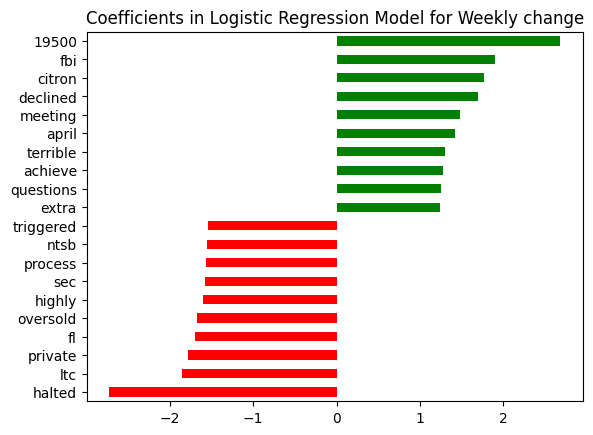

In [74]:
plot_imp_vars(log_reg_weekly.coef_[0], "Weekly change", vectorizer_weekly)

### Monthly Model

In [56]:
vectorizer_monthly = TfidfVectorizer(stop_words='english', max_features=2000)

# Data
X_train = vectorizer_monthly.fit_transform(train_df_m_cleaned['body'])
X_test = vectorizer_monthly.transform(test_df_m_cleaned['body'])
y_train = train_df_m_cleaned['Target']
y_test = test_df_m_cleaned['Target']

# Monthly model
log_reg_monthly = LogisticRegression(random_state=42, max_iter=500)
log_reg_monthly.fit(X_train, y_train)

y_pred_monthly = log_reg_monthly.predict(X_test)
print_metrics(y_test, y_pred_monthly)

Accuracy: 0.4891
AUC score: 0.4891
classification_report:
               precision    recall  f1-score   support

           0       0.49      0.37      0.42      5000
           1       0.49      0.60      0.54      5000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.49      0.49      0.48     10000



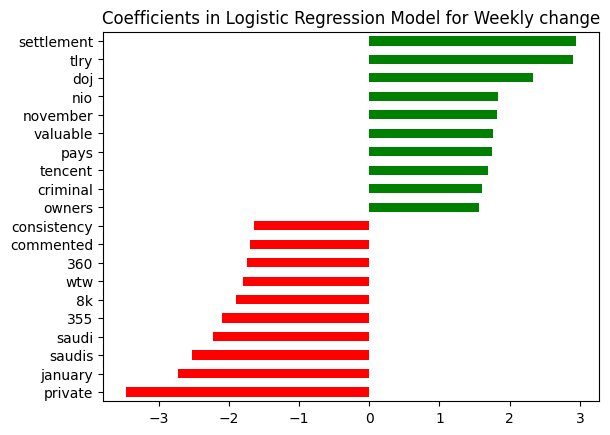

In [57]:
plot_imp_vars(log_reg_monthly.coef_[0], "Weekly change", vectorizer_monthly)

### Quarterly Model

In [58]:
vectorizer_quarterly = TfidfVectorizer(stop_words='english', max_features=2000)

# Data
X_train = vectorizer_quarterly.fit_transform(train_df_q_cleaned['body'])
X_test = vectorizer_quarterly.transform(test_df_q_cleaned['body'])
y_train = train_df_q_cleaned['Target']
y_test = test_df_q_cleaned['Target']

# Quarterly model
log_reg_quarterly = LogisticRegression(random_state=42, max_iter=500)
log_reg_quarterly.fit(X_train, y_train)

y_pred_quarterly = log_reg_quarterly.predict(X_test)
print_metrics(y_test, y_pred_quarterly)

Accuracy: 0.4828
AUC score: 0.48279999999999995
classification_report:
               precision    recall  f1-score   support

           0       0.48      0.47      0.48      5000
           1       0.48      0.50      0.49      5000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



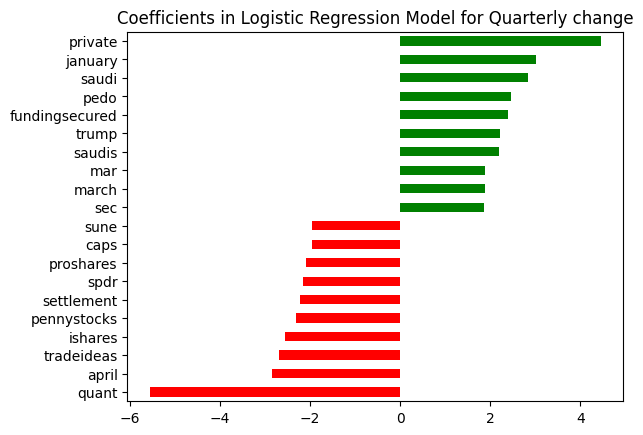

In [59]:
plot_imp_vars(log_reg_quarterly.coef_[0], "Quarterly change", vectorizer_quarterly)

#### Saving training and testing data

In [60]:
# Dictionary mapping DataFrame variable names to their desired CSV filenames
dataframes = {
    'train_df_w_cleaned': 'train_data_w.csv',
    'test_df_w_cleaned': 'test_data_w.csv',
    'train_df_m_cleaned': 'train_data_m.csv',
    'test_df_m_cleaned': 'test_data_m.csv',
    'train_df_q_cleaned': 'train_data_q.csv',
    'test_df_q_cleaned': 'test_data_q.csv'
}

# Saving DataFrames to CSV and prepare to zip them
for df_name, filename in dataframes.items():
    # Save each DataFrame to a CSV file
    eval(df_name).to_csv(filename, index=False)

# Creating a zip file and add all CSV files
with zipfile.ZipFile('all_tesla_data.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    for filename in dataframes.values():
        zipf.write(filename)

# Removing CSV files after zipping
for filename in dataframes.values():
    os.remove(filename)